In [38]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

pd.set_option('display.max_rows', 500)

# General Blueprint 

1. Data import and Early EDA
2. Data cleaning/ Missing data imputation
3. EDA: Outlier analysis 
4. EDA: Statistical analysis
5. EDA: Feature Selection and Engineering
6. Modelling - Machine Learning: Simple Tree Based Classifier/ kNN Classifier
7. Modelling - Deep Learning: Neural Net
8. Cross Validation (Overfitting/Underfitting) 
9. Evaluation

## Baseline model (Completed)

1. Data import and early EDA 
2. Data cleaning - Delete rows with missing values 
3. Feature Selection - using ANOVA
4. Baseline model - Random Forest Classifier
5. Cross Validation and Hyperparameter Tuning
6. Evaluation

## Early inferences/questions
1. Are there class imbalances in the target variable? Yes, with no clear boundary between 1,3,4
2. How does the input variables vary for the multiclass target? 
3. Are the input variables normally distributed? No
4. Is there any outlier in the input variables, are these outliers specific to one of the class in the target? 
5. Statistical analysis: Are the difference in mean of input variables statistically significant from one target class to another?
6. Are the multiclass target represent different failure modes/ defects in the semiconductor? Maybe


# Baseline EDA and Modelling

In [3]:
data = pd.read_csv("C:/Projects/2021/16_practice/multinomial_classification/data/data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10241 entries, 0 to 10240
Columns: 152 entries, 0 to target
dtypes: float64(143), int64(9)
memory usage: 11.9 MB


In [4]:
data["target"] = data.target.astype('category')

In [5]:
data.target.dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=False)

## Early EDA

Summary statistics: Study kurtosis and skewness of data - check if its normally distributed. 

Further action: Might want to run some normality test on the input variables to double check. 


In [6]:
def summary_statistics(data, dtype):
    if dtype == "numerical":
        df_stats_num = data.describe()

        kurtosis_list = []
        skewness_list = []
        numerical_column_list = [col for col in df_stats_num]
        for col in df_stats_num:
            kurtosis_list.append(data[col].kurtosis())
            skewness_list.append(data[col].skew())

        # Generate a dictionary with column and values 
        new_dict_kurtosis = dict(zip(numerical_column_list,kurtosis_list))
        new_dict_skewness = dict(zip(numerical_column_list,skewness_list))

        # Create a series with the index name
        new_rows_kurtosis = pd.Series(data = new_dict_kurtosis, name='kurtosis')
        new_rows_skewness = pd.Series(data = new_dict_skewness, name='skewness')

        # Append the series of kurtosis and skewness to the .describe() dataframe
        df_stats_num = df_stats_num.append(new_rows_kurtosis, ignore_index=False)
        df_stats_num = df_stats_num.append(new_rows_skewness, ignore_index=False)

        if (len(data) > 10):
            df_stats_num = pd.DataFrame(df_stats_num.transpose())
            
        df_stats_num.loc[df_stats_num['kurtosis'] < 3 , 'kurtosis type'] = 'Platykurtic' # uniform distribution (thin tails)
        df_stats_num.loc[df_stats_num['kurtosis'] == 3 , 'kurtosis type'] = 'Normal - Mesokurtic'
        df_stats_num.loc[df_stats_num['kurtosis'] > 3 , 'kurtosis type'] = 'Leptokurtic' # heavy tails
        df_stats_num.loc[df_stats_num['skewness'] < 0, 'skewness type'] = 'Negatively Skewed'
        df_stats_num.loc[df_stats_num['skewness'] == 0, 'skewness type'] = 'Symmetrical'
        df_stats_num.loc[df_stats_num['skewness'] > 0, 'skewness type'] = 'Positively Skewed'
        
        print("Numeric data \n")
        display(df_stats_num)

    elif dtype == "categorical":
        df_stats_cat = data.describe()
        if (len(data) > 10):
            df_stats_cat = pd.DataFrame(df_stats_cat.transpose())
        print("Categorical data \n")
        display(df_stats_cat)  

In [7]:
print(summary_statistics(data, "numerical"))
# Interpretation: All distributions are not normal and are skewed. 

Numeric data 



count          mean          std           min           25%  \
0    10241.0      0.127977     2.018572     -5.480920     -0.710242   
1    10241.0     -0.018351     0.597846     -0.442000     -0.179000   
2    10241.0     -0.045335     0.637736     -0.647000     -0.303000   
3    10241.0     -0.016402     0.953677     -2.989000     -0.773000   
4    10241.0      0.074057     0.960843     -0.517000     -0.310000   
5    10241.0      0.004281     0.749460     -0.501000     -0.190000   
6    10241.0     -0.007069     0.781811     -0.585000     -0.310000   
7    10241.0     10.162148     1.086576      6.931490      9.364720   
8    10241.0     -0.037253     0.218479     -0.190000     -0.059000   
9    10241.0    440.690561    22.920082    373.688000    427.281000   
10   10241.0      0.029022     1.075720     -1.385000     -0.662000   
11   10241.0      1.295237     0.305353      0.877773      1.064150   
12   10241.0      5.554926    14.505937      0.000000      2.000000   
13   10241.0      0.003297     0.003882     -0.039829      0.000953   
14   10241.0     -0.019323     0.747433     -0.522000     -0.323000   
15   10241.0  24805.348892  8106.139945   7107.000000  18904.000000   
16   10241.0     -0.006271     0.704534     -0.712000     -0.305000   
17   10241.0     -0.021998     0.527458     -0.241000     -0.128000   
18   10241.0     -0.021107     0.932992     -2.424431     -0.740943   
19   10241.0      0.999999     0.001532      0.997288      0.998665   
20   10241.0    100.759386    35.643529      5.555556     75.205480   
21   10241.0     73.867717     1.528778     69.598000     72.814000   
22   10241.0      0.078163     1.188845     -0.841000     -0.475000   
23   10241.0    815.804023  3378.012943      8.000000     55.000000   
24   10241.0      0.000021     0.002991     -0.007666     -0.002520   
25   10241.0     -0.005911     0.003722     -0.019830     -0.008380   
26   10241.0      0.800015     0.002980      0.793482      0.797477   
27   10241.0     -0.011853     0.554180     -0.401000     -0.193000   
28   10241.0     -0.022019     0.424431     -0.621000     -0.091000   
29   10241.0     -0.016284     0.222847     -0.391000     -0.033000   
30   10241.0     -0.014501     0.666803     -0.388000     -0.178000   
31   10241.0      0.003788     0.002593     -0.002489      0.002905   
32   10241.0      0.666202     0.013405      0.614540      0.656920   
33   10241.0     -0.013871     0.332098     -0.756000     -0.031000   
34   10241.0     -0.022586     0.375170     -0.444000     -0.094000   
35   10241.0   3226.648746   246.502583   2899.020000   3045.650000   
36   10241.0     -0.028186     0.921602     -1.474000     -0.919000   
37   10241.0     -0.039001     0.228704     -0.226000     -0.066000   
38   10241.0      0.002625     0.997356     -4.468000     -0.632000   
39   10241.0      0.045210     1.063515     -0.629000     -0.418000   
40   10224.0      0.000303     1.019063     -5.726388     -0.410945   
41   10241.0      0.133723     0.712889     -2.811000     -0.696000   
42   10241.0     94.360955     1.767434     61.784000     93.290000   
43   10241.0      0.092128     1.217502     -0.921000     -0.497000   
44   10241.0      0.112985     1.284451     -0.710000     -0.426000   
45   10241.0     -0.016920     0.346279     -0.577000     -0.055000   
46   10241.0     -0.026017     0.510106     -0.262000     -0.164000   
47   10241.0    -18.423399    12.428531   -587.579000    -18.776700   
48   10241.0     96.528978    20.742700     53.010000     82.226800   
49   10241.0      1.500109     0.006927      1.485090      1.494140   
50   10241.0    749.966355   155.519446    563.029000    641.556000   
51   10241.0     -0.004967     0.999343     -5.664000     -0.629000   
52   10241.0     -0.024786     0.215491     -0.119000     -0.056000   
53   10241.0     -0.028969     0.399535     -0.223000     -0.099000   
54   10241.0      0.180086     0.001002      0.110569      0.179530   
55   10241.0     -3.286689    4

None


Text(0.5, 1.03, 'Frequency of Target Variable')

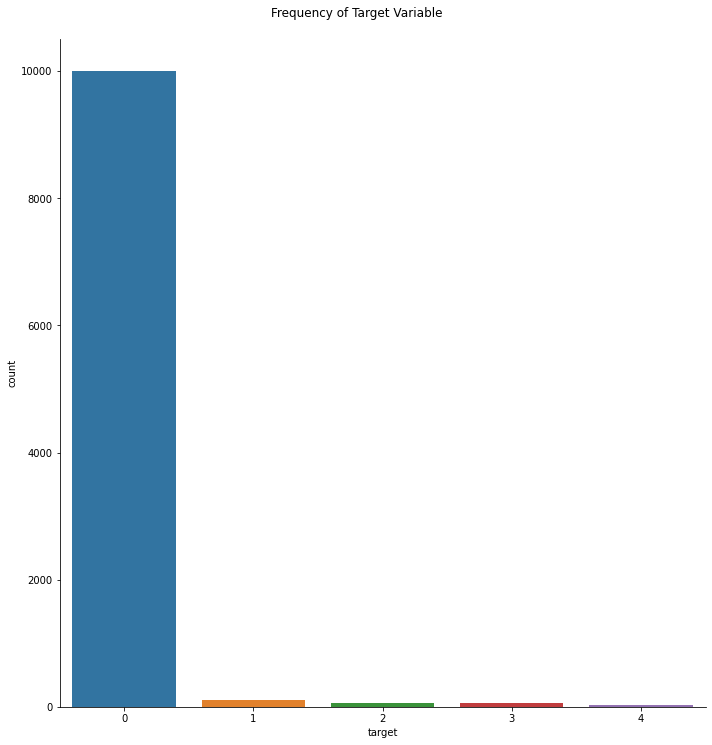

In [8]:
# Check for class imbalances 
g = sns.catplot(x = 'target', data = data, kind = "count",order = data["target"].value_counts().index, height=10, aspect = 1)
g.fig.suptitle("Frequency of Target Variable", y = 1.03, size = 12)

# Notable class imbalance where 0 is majority - assuming this is normal behaviour, label 1-4 assuming is defect
# If the statement above holds true, anomaly detection models would work best - but most often binary classification,
# perhaps a dual stage prediction - first one-class SVM/ PCA based anomaly detection, then based on the anomalies identified
# further classify them into 1,2,3 and 4?
# 1. Baseline model with just a simple classifier
# 2. Baseline model with SMOTE sampling
# 3. Neural nets with SMOTE sampling
# 4. Dual-stage modelling 
# Monitor the time taken required to build these model - the simplest model with easy maintenability and low computation time would be the final results

In [9]:
data.shape
# There is a huge number of variables - we can do feature selection + PCA for dimensionality reduction 

(10241, 152)

## Missing data analysis and Simple data cleaning 

In [10]:
# The following columns having missing values
data.isna().sum()[data.isna().sum() != 0]

40     17
69     12
75      9
80     56
111     4
dtype: int64

In [11]:
columns = ["40", "69", "75", "80", "111", "target"]
missing_data = data[columns]
missing_data[missing_data.isna().any(axis=1)]
# most missingness comes with target = '0'

40       69         75        80      111 target
81     0.698054  3.44539  -0.670855       NaN  3.42735      0
181   -1.596076  3.47904  -2.081810       NaN  3.47060      0
233    0.104307  3.42912   0.128116       NaN  3.43517      0
361    0.482725      NaN   0.148508 -0.009092  3.47382      0
567    0.487072      NaN  -2.819315 -0.004127  3.50454      0
876         NaN  3.42237   0.161964 -0.000749  3.45388      0
922   -2.749503      NaN  -0.100649 -0.010835  3.52275      0
1023  -0.829196  3.49661        NaN -0.006790  3.44287      0
1059  -0.918023  3.48828   0.852740       NaN  3.44567      0
1073  -2.149643  3.43330   0.469294       NaN  3.43504      0
1115  -0.889835  3.49796  -0.618804       NaN  3.43671      0
1141   0.910740  3.49603   1.213635       NaN  3.46436      0
1179   0.263204  3.45741        NaN  0.003388  3.42682      0
1224  -1.639703  3.43694   0.240667       NaN  3.48930      0
1273        NaN  3.46110  -0.389752  0.001887  3.43779      0
1381        NaN  3.45247  -1.688336 -0.007630  3.43067      0
1449   0.318396  3.46908   0.515263       NaN  3.47698      0
1477        NaN  3.45942   6.006542  0.004446  3.48253      0
1547  -0.289886  3.46857        NaN  0.009429  3.49007      0
1590   0.094952  3.46858        NaN  0.010630  3.48874      0
1648        NaN  3.48993   0.378081  0.002099  3.43401      0
1795   0.692666  3.46458  -2.221563       NaN  3.45943      0
1849  -1.582187  3.43015   0.252452       NaN  3.42443      0
1912        NaN  3.42486   0.052540 -0.007213  3.43357      0
1935   0.047570  3.46762   0.990371       NaN  3.51493      0
1989  -0.464399  3.45546  -0.262148       NaN  3.49449      0
2003  -0.589607  3.47127  -1.452133       NaN  3.47154      0
2054   0.285081  3.45337  -0.915133       NaN  3.48383      0
2103  -0.046310  3.53028   0.742198       NaN  3.47360      0
2107  -1.353814  3.48733   0.283810       NaN  3.45171      0
2246   0.632511  3.45273  -0.283804       NaN  3.45309      0
2315  -0.094150  3.43746  -0.689732       NaN  3.45083      0
2493  -0.159082  3.46045  -0.081121       NaN  3.45123      0
2549        NaN  3.48964   0.864731  0.008161  3.45859      0
2898   0.917399  3.45850  -0.348659       NaN  3.48522      0
3009  -1.815322  3.44030  -0.064749       NaN  3.49026      0
3069  -0.671957  3.46658  -0.443238       NaN  3.41778      0
3469   0.051652  3.48666   0.688295       NaN  3.45949      0
3529   0.039442  3.42181   0.082972       NaN  3.47456      0
3536  -0.174407  3.47545  -0.185466       NaN  3.46641      0
3609        NaN  3.43037   0.162582 -0.010385  3.42278      0
3931        NaN  3.44700  -0.064512 -0.011484  3.47015      0
4008        NaN  3.48626  -2.970049 -0.011708  3.43548      0
4365        NaN  3.45995   0.371645 -0.008860  3.44250      0
4494   0.901180  3.48687   0.196568       NaN  3.44926      0
4553   0.790741  3.49021  -0.242794       NaN  3.45279      0
4662        NaN  3.43227  -3.080671  0.005035  3.42456      0
4681  -0.595338  3.44787        NaN -0.009885  3.48600      0
4804   0.714462      NaN   0.111120  0.004231  3.52626      0
4885   0.858669  3.48856   0.350133       NaN  3.44100      0
4940   1.721259      NaN   0.266757 -0.001383  3.46540      0
4984        NaN  3.47340   0.423966 -0.010492  3.47749      0
5101   0.019718  3.49699  -1.541082       NaN  3.45210      0
5151   0.015296  3.45827  -0.360437       NaN  3.46105      0
5359   0.741218  3.43322  -0.330072       NaN  3.48758      0
5604  -0.082915  3.46610   0.251001       NaN  3.43353      0
5623        NaN  3.44933   0.471616  0.001956  3.44017      0
5762  -4.161102  3.49204        NaN -0.096623  3.44772      0
5816  -0.268302      NaN   0.347432 -0.010443  3.44351      0
5854   0.265296  3.45431        NaN  0.010702  3.43716      0
5938   0.764043  3.38498   1.949053 -0.005679      NaN      0
5965   0.298533  3.42539   0.740725       NaN  3.43202      0
5969  -0.451992  3.42183        NaN -0.000537  3.45338      0
6006  -1.441092  3.48746   2.740179       NaN

<Figure size 864x576 with 0 Axes>

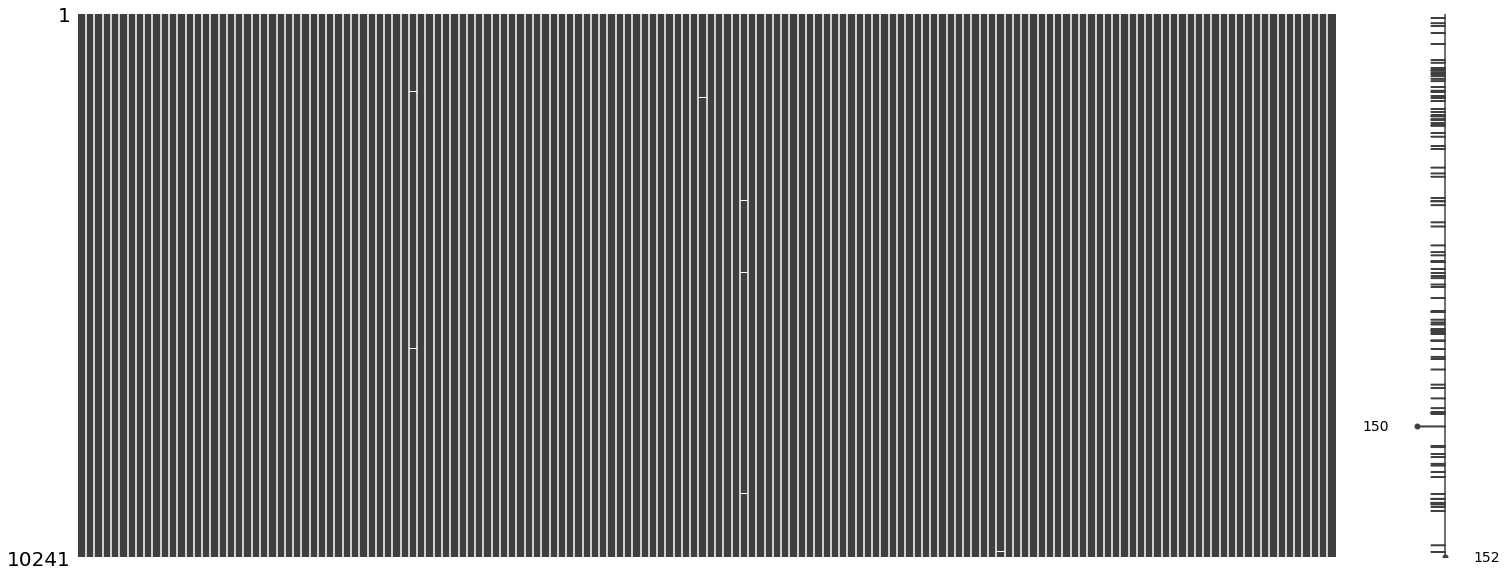

In [12]:
missing_col = data.isnull().sum()
percent_missing_col = round(missing_col * 100 / len(data), 2)
plt.figure(figsize=(12,8))
ax = msno.matrix(data)
fig = plt.show()
# Missingness almost unnoticeable and is missing at random, just remove the rows for now

In [13]:
clean_data = data[~data.isna().any(axis=1)]
clean_data.isna().sum().sum()

0

## Check behavior of input variables to target

Here we would like to see what's the behavior of the input variables when the target is 1,2,3,4

The challenge of this dataset is the many input variables and there is no hint on the input variables name. For instance, if i perform classification on iris species, i can roughly guess that sepal length and sepal width has some correlation between them, same goes to petal length and petal width. Here, we don't have the luxury and that's why its fun!

In [15]:
clean_data[:5]

0      1      2      3      4      5      6         7      8  \
0  0.899922 -0.161 -0.244  1.022 -0.304 -0.156 -0.310  12.06400 -0.051   
1  1.050575 -0.285 -0.298 -0.776 -0.263 -0.118  1.526   9.92919 -0.059   
2 -1.206626 -0.202 -0.289  1.099 -0.302 -0.176 -0.330  11.07720 -0.075   
3 -1.082795 -0.125  1.748  2.167 -0.239 -0.242 -0.292   9.39798 -0.045   
4  0.891784 -0.219  1.757 -0.782 -0.268 -0.099 -0.239   9.42913 -0.067   

         9  ...    142    143       144     145       146      147      148  \
0  462.092  ...  764.3 -0.005  0.060303  13.383  0.819909 -0.18291 -0.12259   
1  466.645  ...  532.5 -0.023  0.044870  14.887  1.642613 -0.19030 -0.12308   
2  419.784  ...  651.4 -0.035  0.054069  -2.932  0.464588 -0.18631 -0.12413   
3  433.346  ...  603.4 -0.008  0.043571 -44.990  0.335563 -0.19257 -0.11309   
4  429.280  ...  417.4 -0.025  0.041588 -12.205 -0.728111 -0.18187 -0.12143   

        149      150  target  
0  0.060684  17.1094       0  
1  0.045252  17.0932       0  
2  0.050065  17.2080       0  
3  0.045097  17.5977       0  
4  0.043112  17.2664       0  

[5 rows x 152 columns]

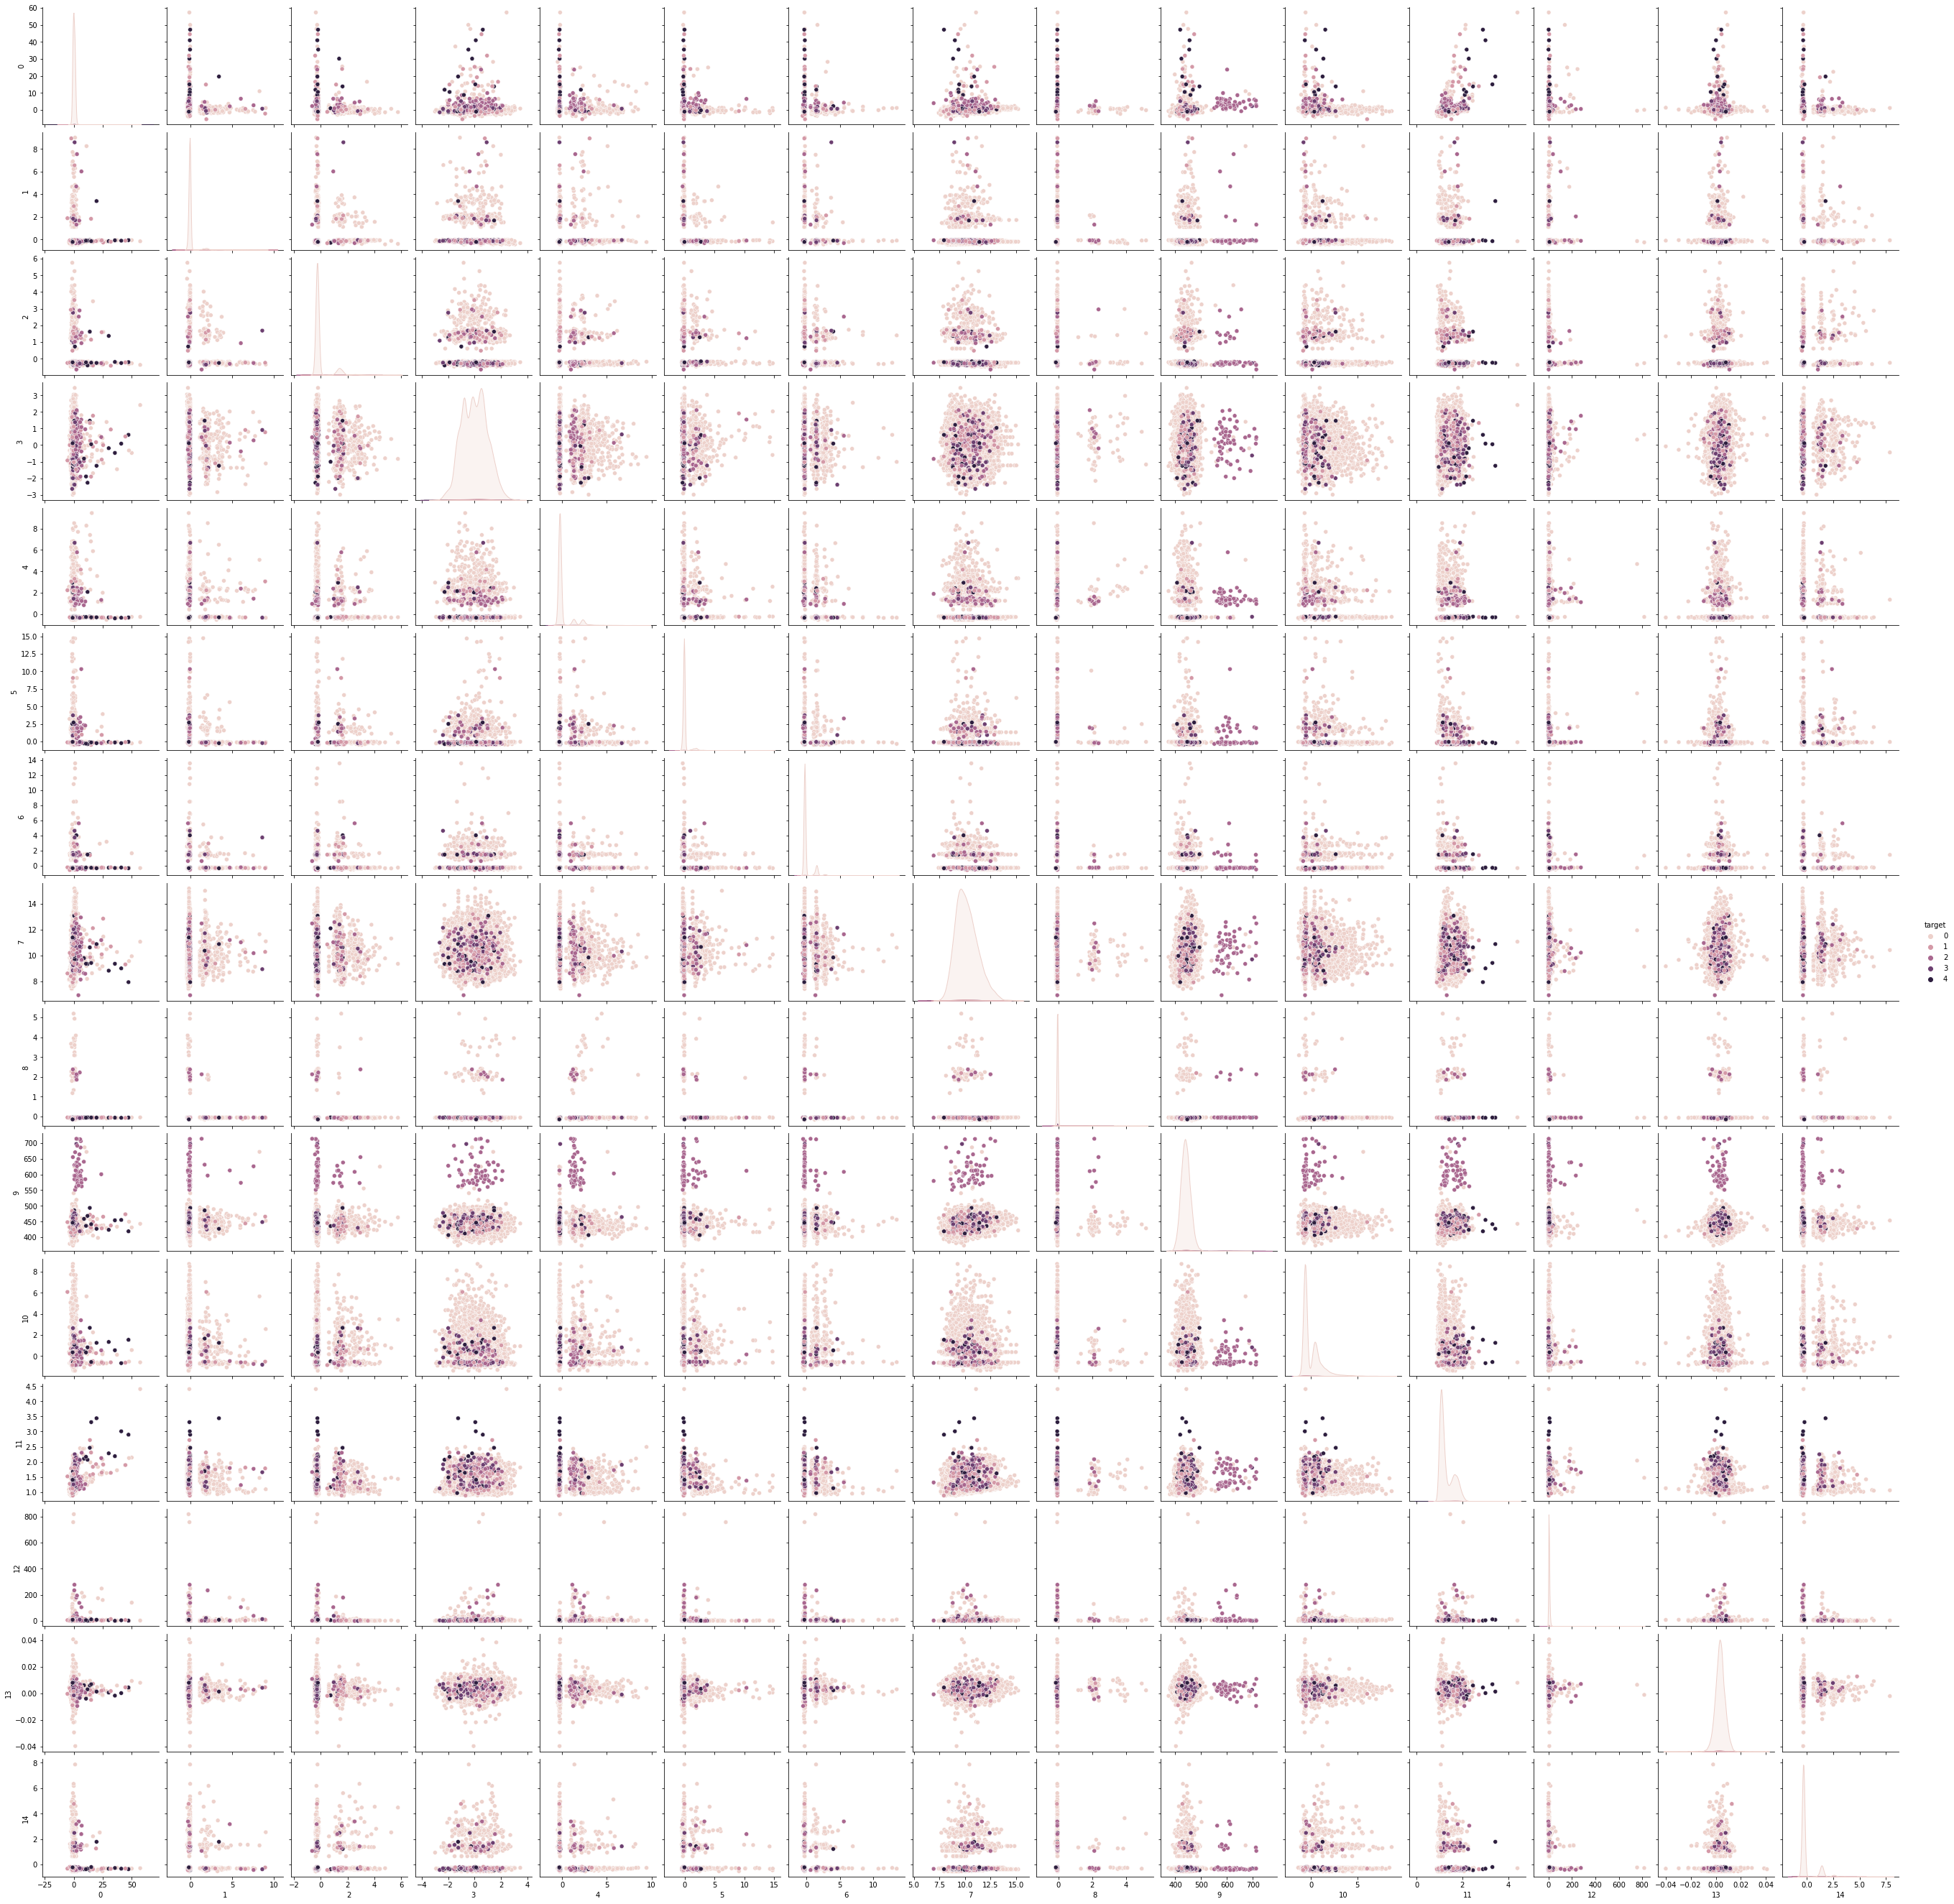

In [60]:
# Let's take a quick glance of pairplot of 15 columns to the target
subset1 = pd.concat([clean_data.iloc[:, :15], clean_data['target']], axis=1)
sns.pairplot(subset1, hue="target")
# Interpretation: The disparity among target 1-4 is not significant - makes it hard to classify 
# Column 9 seem to be able to differentiate 1 from the rest
# but doing this manual checks will be too slow for my analysis - let me try PCA

The number of PCs for which explained variance is 95%: 110


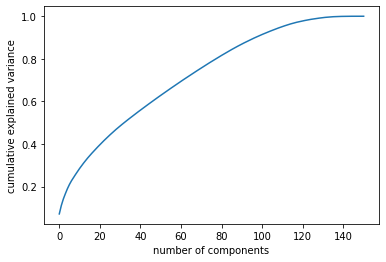

In [14]:
# Perform PCA
x = clean_data.loc[:, ~clean_data.columns.isin(['target'])].values
y = clean_data.loc[:,['target']].values
x = StandardScaler().fit_transform(x)
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# Choose the no. of PCs that will capture 95% of the variance
pca_variance = np.cumsum(pca.explained_variance_ratio_)
index = np.where(pca_variance > 0.95)[0][0]
print('The number of PCs for which explained variance is 95%: {}'.format(index))

Explained variation per principal component: [0.07184303 0.03945226 0.03067298 0.02495157 0.02316056 0.02003177
 0.01728029 0.0151291  0.01450979 0.01438108 0.01375716 0.01305863
 0.01261268 0.0119536  0.01172985 0.01118025 0.01061215 0.01035019
 0.01027159 0.00996258 0.00977891 0.00972937 0.00953032 0.00930285
 0.00910147 0.00887166 0.00873414 0.00861604 0.00835986 0.00815023
 0.00797224 0.00778302 0.00776388 0.00755633 0.00749377 0.00741419
 0.00737425 0.00732389 0.00724848 0.00718947 0.00716161 0.00707348
 0.00704715 0.00701208 0.00700277 0.00698541 0.00693528 0.00688323
 0.00685721 0.00679322 0.00677861 0.00673082 0.00668015 0.00665986
 0.00662448 0.00657418 0.00657285 0.00653598 0.00651192 0.00648443
 0.00646942 0.00641882 0.00636684 0.0063254  0.00630779 0.00627639
 0.00625098 0.00622444 0.00620744 0.00616787 0.00610894 0.00610454
 0.00606981 0.00600794 0.00598484 0.00590772 0.00589893 0.00586601
 0.00581167 0.00573489 0.00566969 0.00562396 0.00557828 0.00554453
 0.00546871 0.005

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

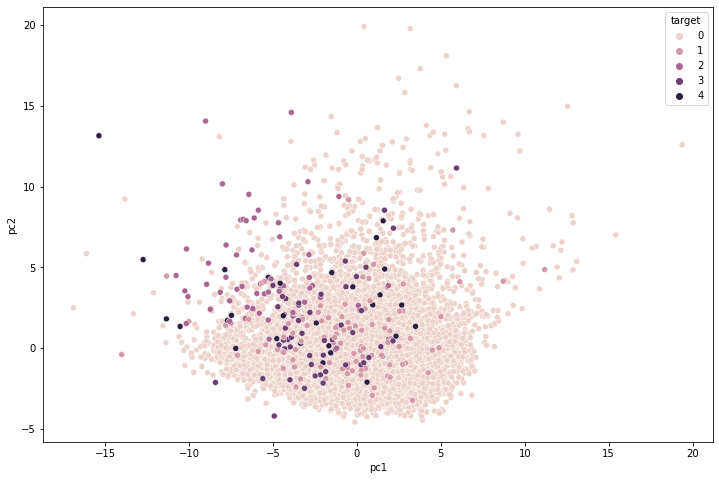

In [15]:
pca = PCA(n_components=110)
pcs = pca.fit_transform(x)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
columns = ['pc'+str(i+1) for i in range(pcs.shape[1])]
pca_df = pd.DataFrame(data= pcs, columns = columns)
target_df = pd.DataFrame(data=y, columns=['target'])
combined_df = pd.concat([pca_df, target_df], axis=1)
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="pc1", y="pc2",
    hue="target",
    data=combined_df,
    legend="full",
)
# Separation is still not clear but dimension is reduced from 151 to 110 (acceptable)

In [125]:
# Here want to find out the two PCs that are able to perform the best separation between 0 and 1-4
# Need to fix the evaluation
# fig, axes = plt.subplots(ncols=10, nrows=11, figsize=(16,10))
  
# for ax in axes: 
#     for col,_ in enumerate(combined_df.columns):
#         sns.scatterplot(
#         x="pc"+str(col+1), y="pc"+str(col+2),
#         hue="target",
#         data=combined_df,
#         legend="full",
#     )
# # depict illustartion
# fig.tight_layout()
# plt.show()

## Baseline Feature Selection using Pearson Correlation and ANOVA

Assuming all variables are numerical for now. 

In [18]:
# # normal 
# Skipped for now, taking too long to run
# fig = plt.figure(figsize=(20,10))    
# temp_df = pd.concat([clean_data.iloc[:,:5], clean_data['target']], axis=1)
# heat_map = sns.heatmap(temp_df, annot = True, fmt='.2g')
# heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=0)
# plt.show()

In [19]:
# # pca
# Skipped for now, taking too long to run
# fig = plt.figure(figsize=(20,10))               
# heat_map = sns.heatmap(combined_df, annot = True, fmt='.2g')
# heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=0)

In [16]:
# normal
x = clean_data.loc[:, ~clean_data.columns.isin(['target'])].values
y = clean_data.loc[:,['target']].values
x = StandardScaler().fit_transform(x)
selector = SelectPercentile(score_func=f_classif, percentile=10).fit(x, y)
anova_selected_features = np.array(clean_data.loc[:, ~clean_data.columns.isin(['target'])].columns)[selector.get_support()]
print(anova_selected_features)

['0' '9' '25' '47' '50' '56' '64' '73' '75' '98' '100' '108' '128' '133'
 '137']


c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [17]:
# pca
x = combined_df.loc[:, ~combined_df.columns.isin(['target'])].values
y = combined_df.loc[:,['target']].values
x = StandardScaler().fit_transform(x)
selector = SelectPercentile(score_func=f_classif, percentile=10).fit(x, y)
anova_selected_features = np.array(combined_df.loc[:, ~combined_df.columns.isin(['target'])].columns)[selector.get_support()]
print(anova_selected_features)

['pc1' 'pc2' 'pc3' 'pc4' 'pc5' 'pc6' 'pc7' 'pc24' 'pc27' 'pc41' 'pc70']


c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Train Test Split for Modelling

In [18]:
X, y = clean_data.iloc[:,:-1], clean_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [19]:
print(clean_data.target.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
# The proportion is maintained

0    0.976439
1    0.009957
2    0.005718
3    0.005126
4    0.002760
Name: target, dtype: float64
0    0.976479
1    0.010000
2    0.005634
3    0.005070
4    0.002817
Name: target, dtype: float64


<AxesSubplot:ylabel='target'>

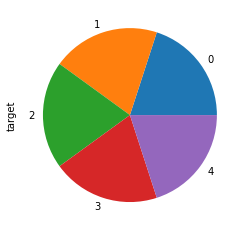

In [20]:
oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

In [21]:
# neural net
ohe = OneHotEncoder()
y_nn = ohe.fit_transform(np.array(clean_data.iloc[:,-1]).reshape(-1, 1)).toarray()
_, _, ynn_train, ynn_test = train_test_split(X, y_nn, stratify=y_nn, test_size=0.3)
print(ynn_train)
print(pd.DataFrame(ynn_train).value_counts())

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
0    1    2    3    4  
1.0  0.0  0.0  0.0  0.0    6933
0.0  1.0  0.0  0.0  0.0      71
     0.0  1.0  0.0  0.0      40
          0.0  1.0  0.0      36
               0.0  1.0      20
dtype: int64


In [22]:
cols = ['0' ,'9', '25', '47', '50', '56', '64' ,'73', '75', '98', '100' ,'108', '128', '133','137']
Xf, yf = clean_data.loc[:,cols], clean_data.iloc[:,-1]
X_ftrain, X_ftest, y_ftrain, y_ftest = train_test_split(Xf, yf, stratify=yf, test_size=0.3)

In [23]:
cols = ['pc1' ,'pc2', 'pc3', 'pc4' ,'pc5' ,'pc6', 'pc7' ,'pc24' ,'pc27' ,'pc41' ,'pc70']
Xp, yp = combined_df.loc[:,cols], combined_df.iloc[:,-1]
X_ptrain, X_ptest, y_ptrain, y_ptest = train_test_split(Xp, yp, stratify=yp, test_size=0.3)

# Baseline Model: RandomForest Classifier

In [30]:
# General function
labels = ["".join("c" + str(i[0])) for i in pd.DataFrame(y_test).value_counts().index]
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [30]:
# X, y = clean_data.iloc[:,:-1], clean_data.iloc[:,-1]
# model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
# def evaluate_model(X, y, model):
#     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#     accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#     return accuracy_scores
# accuracy_scores = evaluate_model(X, y, model)
# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))

In [31]:
# baseline model
rf_model = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
filename = '../models/rf_baselinemodel.sav'
pickle.dump(gridrf_model, open(filename, 'wb'))

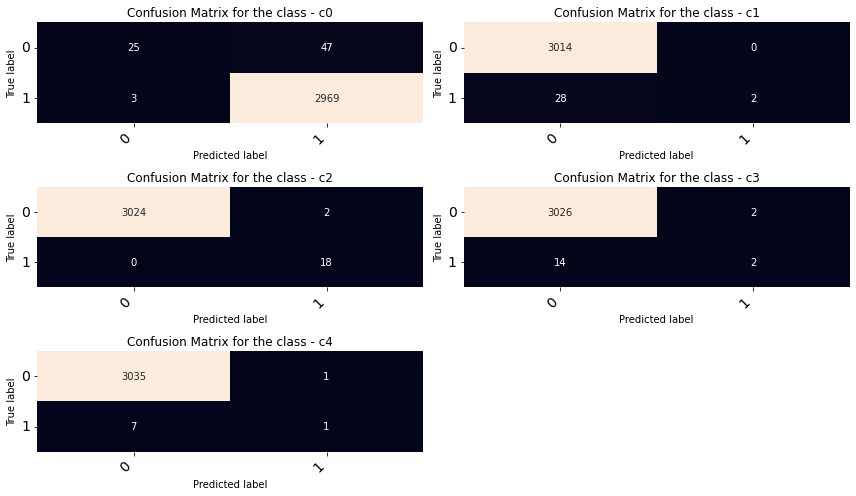

In [33]:
# For baseline
cm = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

# c0 and c2 prediction is fairly well, however c1, c3 and c4 is not great!

In [ ]:
# model with feature selection
rf_fmodel = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_ftrain, y_ftrain)
y_fpred = rf_fmodel.predict(X_ftest)

In [223]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========\n".format(label))
    
    precision = precision_score(y_test, y_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, y_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, y_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    
    print("\n")


# if 1-4 is truly defect, recall (all defects identified) would be a preferred metrics over precision (defects identified amongst normal observations)
# c0 and c2 were predicted well, c1, c3 and c4
# let's see if neural nets can predict the 2,3,4 well

===========Precision, Recall and F1 Score for c0===========

Precision: 0.9857
Recall: 0.9997
F1 score: 0.9926


===========Precision, Recall and F1 Score for c1===========

Precision: 0.5000
Recall: 0.1000
F1 score: 0.1667


===========Precision, Recall and F1 Score for c2===========

Precision: 0.9474
Recall: 1.0000
F1 score: 0.9730


===========Precision, Recall and F1 Score for c3===========

Precision: 1.0000
Recall: 0.2500
F1 score: 0.4000


===========Precision, Recall and F1 Score for c4===========

Precision: 1.0000
Recall: 0.1250
F1 score: 0.2222




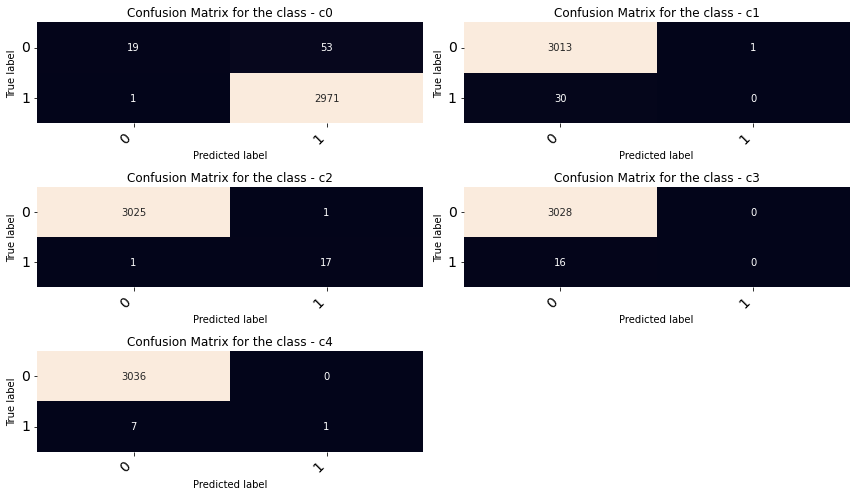

In [34]:
# For feature selection
cm = multilabel_confusion_matrix(y_ftest, y_fpred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

# same or worst outcome than baseline

In [36]:
# model with pca
rf_pmodel = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_ptrain, y_ptrain)
y_ppred = rf_pmodel.predict(X_ptest)

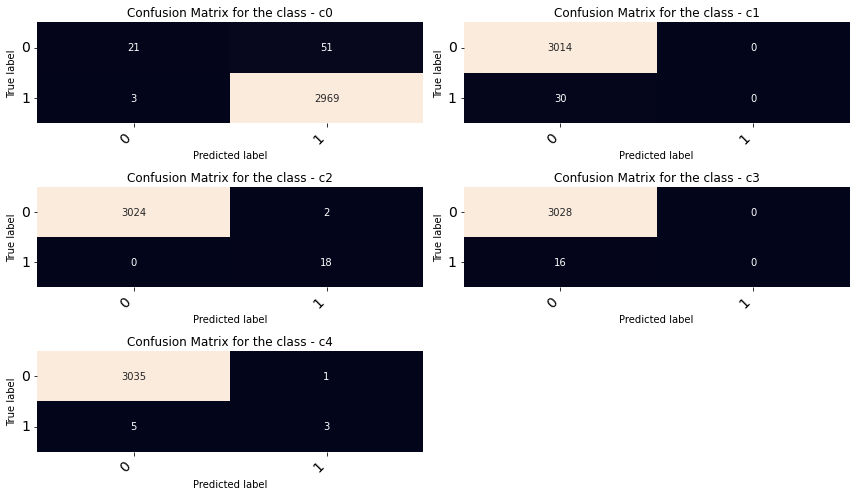

In [37]:
# For pca
cm = multilabel_confusion_matrix(y_ptest, y_ppred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

# same or worst outcome than baseline

In [39]:
# do grid search cv
rfc = RandomForestClassifier(random_state=123)
param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 1000}


In [41]:
# model with pca
gridrf_model = RandomForestClassifier(n_estimators=1000, max_features='auto', max_depth=8, criterion='gini', random_state=123).fit(X_train, y_train)
ygrid_pred = gridrf_model.predict(X_test)
filename = '../models/rf_gridmodel.sav'
pickle.dump(gridrf_model, open(filename, 'wb'))

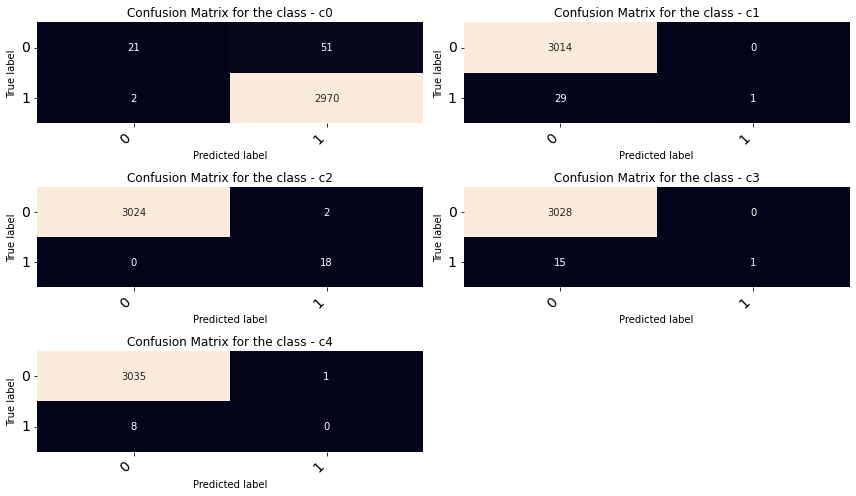

In [48]:
# For grid search cv
cm = multilabel_confusion_matrix(y_test, ygrid_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [68]:
# support vector machine - linear kernel
clf = svm.LinearSVC(random_state=123)
clf.fit(X_train, y_train)
y_svmpred = clf.predict(X_test)

c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


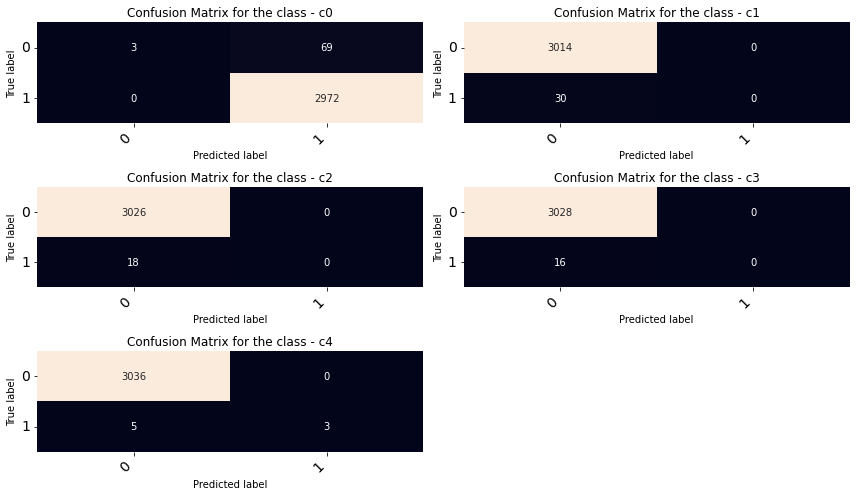

In [69]:
cm = multilabel_confusion_matrix(y_test, y_svmpred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [71]:
# stochastic gradient descent
clf_SGD = SGDClassifier(max_iter=1000, tol=1e-3)
clf_SGD.fit(X_train, y_train)
y_sgdpred = clf_SGD.predict(X_test)

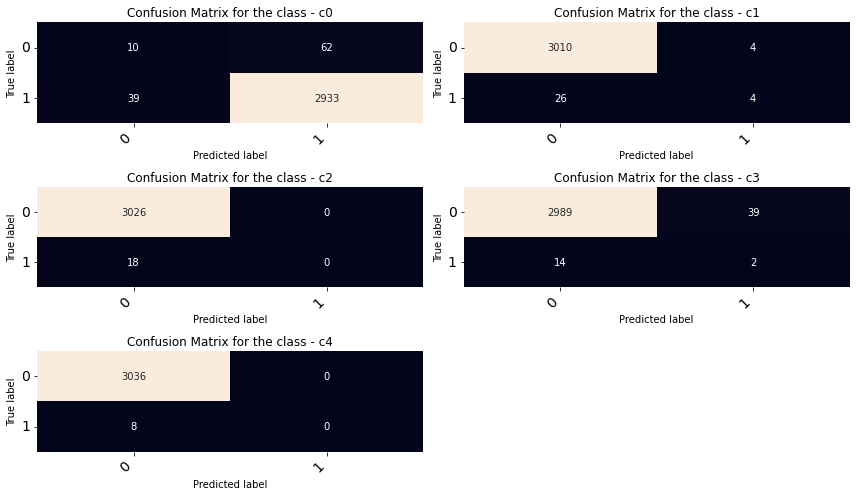

In [72]:
cm = multilabel_confusion_matrix(y_test, y_sgdpred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [73]:
# support vector machine - polynomial
clf_poly = svm.SVC(kernel='poly', random_state=123)
clf_poly.fit(X_train, y_train)
y_polypred = clf_poly.predict(X_test)

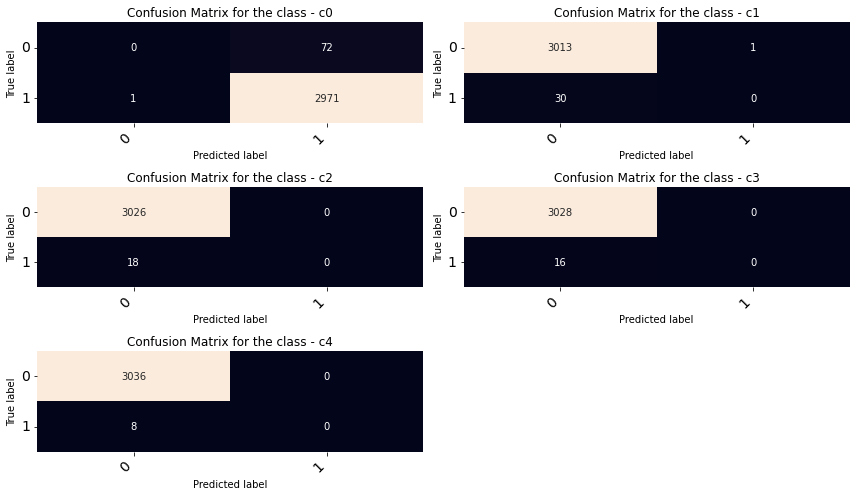

In [74]:
cm = multilabel_confusion_matrix(y_test, y_polypred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

# Model Selection: Logistic Regression & LightGBM

In [75]:
# logistic regression
# Reference: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(X_train, y_train)

# Predicting on the test data
lr_pred = lr.predict(X_test)

c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


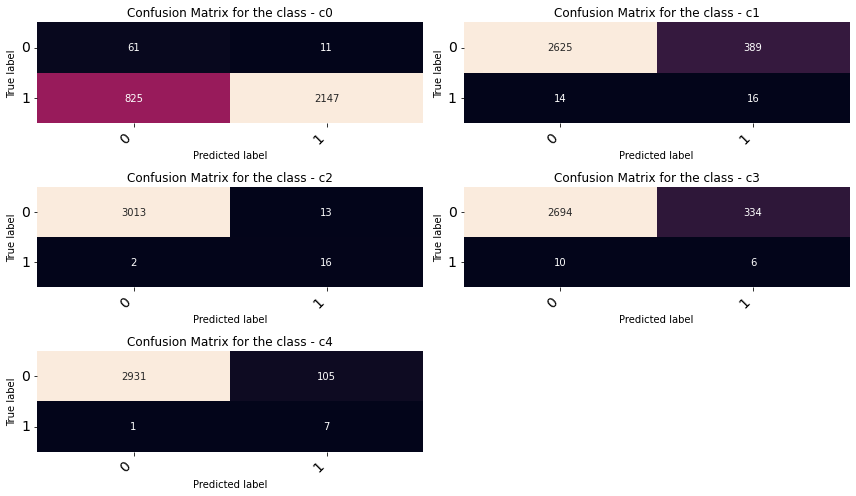

In [76]:
cm = multilabel_confusion_matrix(y_test, lr_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [92]:
print(y_test.value_counts())
print(pd.DataFrame(lr_pred).value_counts())

0    2972
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    2158
1     405
3     340
4     112
2      29
dtype: int64


In [77]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========\n".format(label))
    
    precision = precision_score(y_test, lr_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, lr_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, lr_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    
    print("\n")


# if 1-4 is truly defect, recall (all defects identified) would be a preferred metrics over precision (defects identified amongst normal observations)
# c0 and c2 were predicted well, c1, c3 and c4
# let's see if neural nets can predict the 2,3,4 well

===========Precision, Recall and F1 Score for c0===========

Precision: 0.9949
Recall: 0.7224
F1 score: 0.8370


===========Precision, Recall and F1 Score for c1===========

Precision: 0.0395
Recall: 0.5333
F1 score: 0.0736


===========Precision, Recall and F1 Score for c2===========

Precision: 0.5517
Recall: 0.8889
F1 score: 0.6809


===========Precision, Recall and F1 Score for c3===========

Precision: 0.0176
Recall: 0.3750
F1 score: 0.0337


===========Precision, Recall and F1 Score for c4===========

Precision: 0.0625
Recall: 0.8750
F1 score: 0.1167




In [84]:
# logistic regression with SMOTE
# Reference: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
lro = LogisticRegression(solver='newton-cg', class_weight='balanced')
lro.fit(X_otrain, y_otrain)

# Predicting on the test data
lro_pred = lro.predict(X_test)

c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


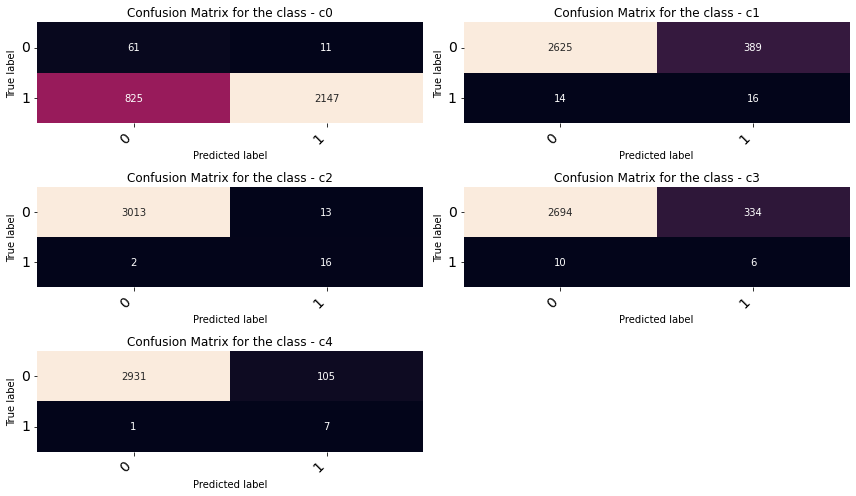

In [85]:
cm = multilabel_confusion_matrix(y_test, lr_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [91]:
print(y_test.value_counts())
print(pd.DataFrame(lro_pred).value_counts())

0    2972
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    2201
1     405
3     340
4      72
2      26
dtype: int64


In [86]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    
    precision = precision_score(y_test, lro_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, lro_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, lro_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    


# if 1-4 is truly defect, recall (all defects identified) would be a preferred metrics over precision (defects identified amongst normal observations)
# c0 and c2 were predicted well, c1, c3 and c4
# let's see if neural nets can predict the 2,3,4 well

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9950
Recall: 0.7369
F1 score: 0.8467
===========Precision, Recall and F1 Score for c1===========
Precision: 0.0395
Recall: 0.5333
F1 score: 0.0736
===========Precision, Recall and F1 Score for c2===========
Precision: 0.6154
Recall: 0.8889
F1 score: 0.7273
===========Precision, Recall and F1 Score for c3===========
Precision: 0.0176
Recall: 0.3750
F1 score: 0.0337
===========Precision, Recall and F1 Score for c4===========
Precision: 0.0972
Recall: 0.8750
F1 score: 0.1750


In [93]:
# rfmodel with oversampling
rfo_model = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
yo_pred = rfo_model.predict(X_test)

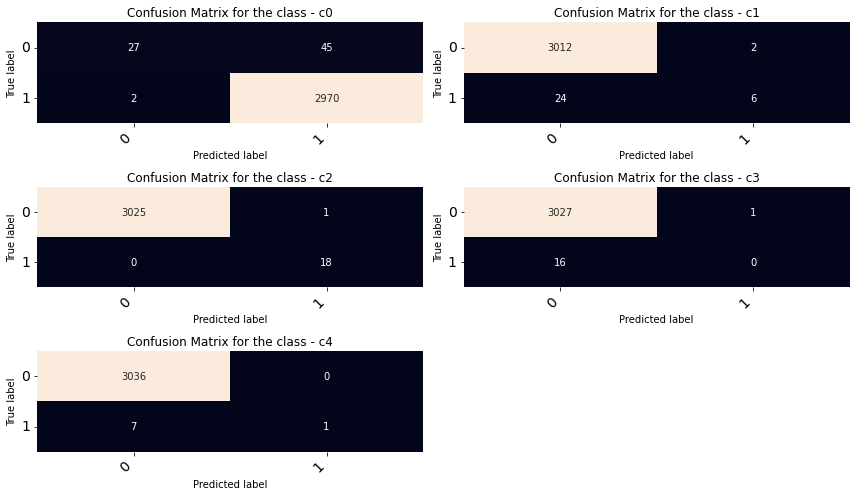

In [99]:
cm = multilabel_confusion_matrix(y_test, yo_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [98]:
print(y_test.value_counts())
print(pd.DataFrame(yo_pred).value_counts())

0    2972
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    3015
2      19
1       8
3       1
4       1
dtype: int64


In [97]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    
    precision = precision_score(y_test, yo_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, yo_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, yo_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9851
Recall: 0.9993
F1 score: 0.9921
===========Precision, Recall and F1 Score for c1===========
Precision: 0.7500
Recall: 0.2000
F1 score: 0.3158
===========Precision, Recall and F1 Score for c2===========
Precision: 0.9474
Recall: 1.0000
F1 score: 0.9730
===========Precision, Recall and F1 Score for c3===========
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000
===========Precision, Recall and F1 Score for c4===========
Precision: 1.0000
Recall: 0.1250
F1 score: 0.2222


In [102]:
# lightgbm model with oversampling
# Most of the sklearn classifier modeling libraries and even some boosting based libraries like LightGBM 
# and catboost have an in-built parameter “class_weight” which helps us optimize the scoring for the minority 
# class just the way we have learned so far.
lgbmo_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
ylgbmo_pred = lgbmo_model.predict(X_test)

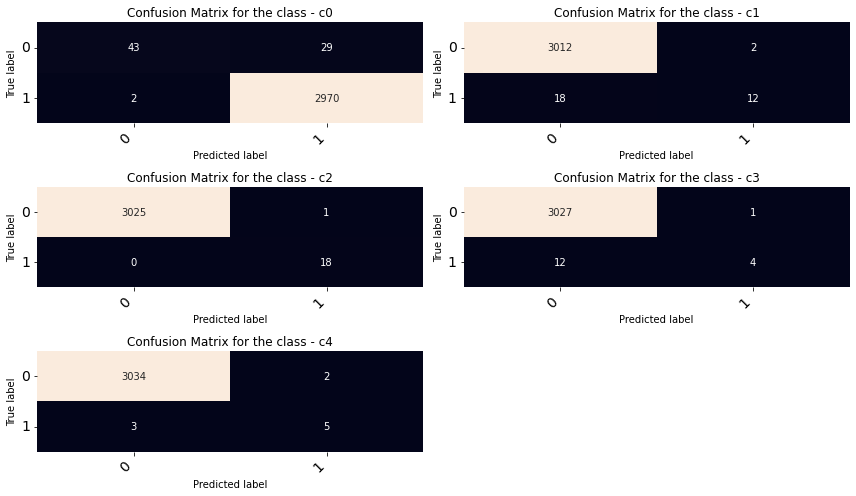

In [104]:
cm = multilabel_confusion_matrix(y_test, ylgbmo_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [106]:
print(y_test.value_counts())
print(pd.DataFrame(ylgbmo_pred).value_counts())

0    2972
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    2999
2      19
1      14
4       7
3       5
dtype: int64


In [108]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    
    precision = precision_score(y_test, ylgbmo_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, ylgbmo_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, ylgbmo_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9903
Recall: 0.9993
F1 score: 0.9948
===========Precision, Recall and F1 Score for c1===========
Precision: 0.8571
Recall: 0.4000
F1 score: 0.5455
===========Precision, Recall and F1 Score for c2===========
Precision: 0.9474
Recall: 1.0000
F1 score: 0.9730
===========Precision, Recall and F1 Score for c3===========
Precision: 0.8000
Recall: 0.2500
F1 score: 0.3810
===========Precision, Recall and F1 Score for c4===========
Precision: 0.7143
Recall: 0.6250
F1 score: 0.6667


In [110]:
# lightgbm model without oversampling
# Most of the sklearn classifier modeling libraries and even some boosting based libraries like LightGBM 
# and catboost have an in-built parameter “class_weight” which helps us optimize the scoring for the minority 
# class just the way we have learned so far.
lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_train, y_train)
ylgbm_pred = lgbm_model.predict(X_test)

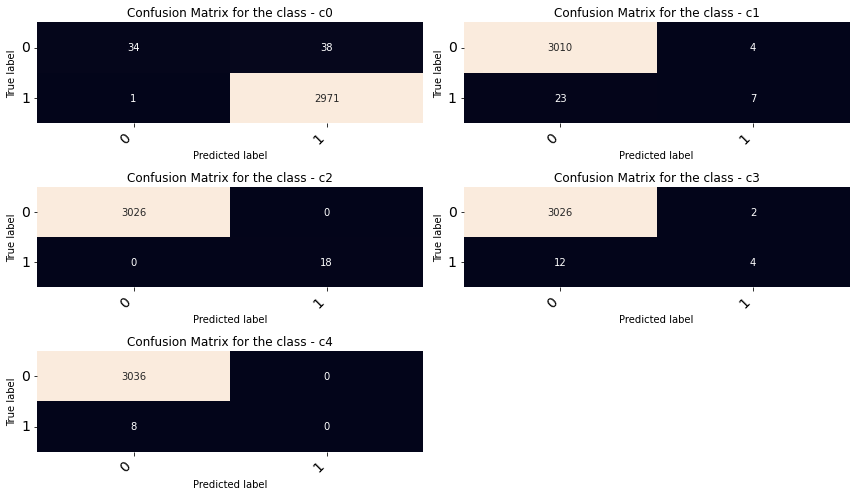

In [111]:
cm = multilabel_confusion_matrix(y_test, ylgbm_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [112]:
print(y_test.value_counts())
print(pd.DataFrame(ylgbm_pred).value_counts())

0    2972
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    3009
2      18
1      11
3       6
dtype: int64


In [113]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    
    precision = precision_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9874
Recall: 0.9997
F1 score: 0.9935
===========Precision, Recall and F1 Score for c1===========
Precision: 0.6364
Recall: 0.2333
F1 score: 0.3415
===========Precision, Recall and F1 Score for c2===========
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000
===========Precision, Recall and F1 Score for c3===========
Precision: 0.6667
Recall: 0.2500
F1 score: 0.3636
===========Precision, Recall and F1 Score for c4===========
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


===========Precision, Recall and F1 Score for c0===========
Precision: 0.9855
Recall: 0.9993
F1 score: 0.9924
===========Precision, Recall and F1 Score for c1===========
Precision: 0.5556
Recall: 0.1667
F1 score: 0.2564
===========Precision, Recall and F1 Score for c2===========
Precision: 0.9444
Recall: 0.9444
F1 score: 0.9444
===========Precision, Recall and F1 Score for c3===========
Precision: 0.3333
Recall: 0.0625
F1 score: 0.1053
===========Precision, Recall and F1 Score for c4===========
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


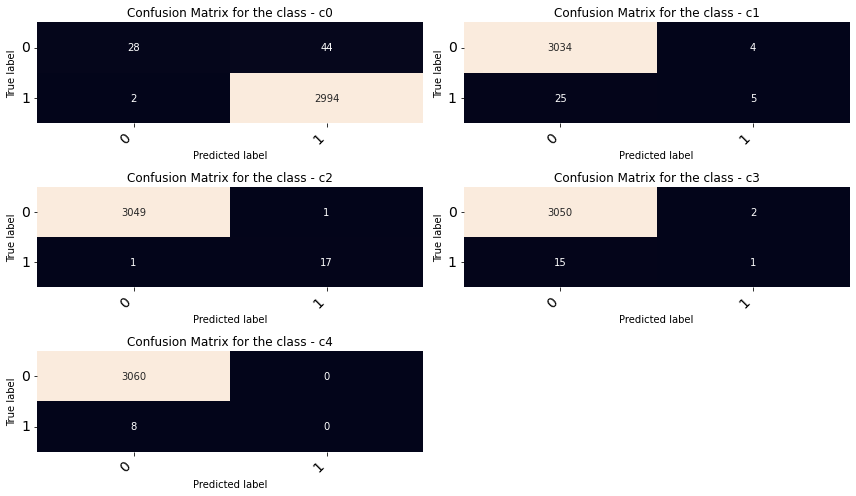

In [117]:
# Perform transformation to heavily skewed dataset, hoping to have better results
data_transformed = pd.read_csv("../data/data_transformed.csv", index_col=0)
data_transformed = data_transformed[~data_transformed.isna().any(axis=1)]
X, y = data_transformed.iloc[:,:-1], data_transformed.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# oversample = SMOTE()
# X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
# y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_train, y_train)
ylgbm_pred = lgbm_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, ylgbm_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)


===========Precision, Recall and F1 Score for c0===========
Precision: 0.9828
Recall: 0.9947
F1 score: 0.9887
===========Precision, Recall and F1 Score for c1===========
Precision: 0.1818
Recall: 0.0667
F1 score: 0.0976
===========Precision, Recall and F1 Score for c2===========
Precision: 0.8462
Recall: 0.6111
F1 score: 0.7097
===========Precision, Recall and F1 Score for c3===========
Precision: 0.6000
Recall: 0.1875
F1 score: 0.2857
===========Precision, Recall and F1 Score for c4===========
Precision: 0.1429
Recall: 0.1250
F1 score: 0.1333
0    2996
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    3032
2      13
1      11
4       7
3       5
dtype: int64


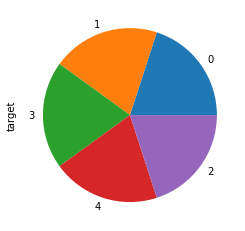

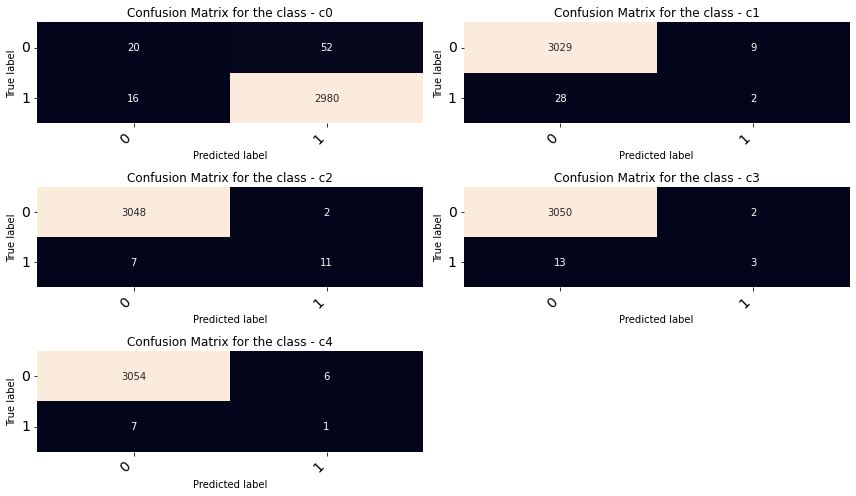

In [34]:
# Perform transformation + Feature Selection (Variance Threshold)
data_transformed = pd.read_csv("../data/data_transformed.csv")
data_transformed = data_transformed[~data_transformed.isna().any(axis=1)]
cols = ['3', '21', '38', '51', '58', '66', '68', '78', '79', '85', '113', '123',
       '132', '140', '141', '142', '145', '146', '15_sqrt', '20_sqrt',
       '90_sqrt', '109_sqrt', '23_log', '92_log', '47_log']
X, y = data_transformed.loc[:,cols], data_transformed['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
ylgbm_pred = lgbm_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, ylgbm_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)

print(y_test.value_counts())
print(pd.DataFrame(ylgbm_pred).value_counts())

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9896
Recall: 0.9997
F1 score: 0.9946
===========Precision, Recall and F1 Score for c1===========
Precision: 0.9375
Recall: 0.5000
F1 score: 0.6522
===========Precision, Recall and F1 Score for c2===========
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000
===========Precision, Recall and F1 Score for c3===========
Precision: 1.0000
Recall: 0.3125
F1 score: 0.4762
===========Precision, Recall and F1 Score for c4===========
Precision: 1.0000
Recall: 0.3750
F1 score: 0.5455
0    2951
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    2981
2      18
1      16
3       5
4       3
dtype: int64


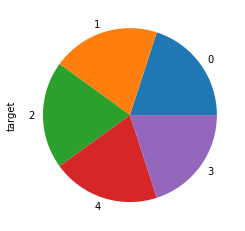

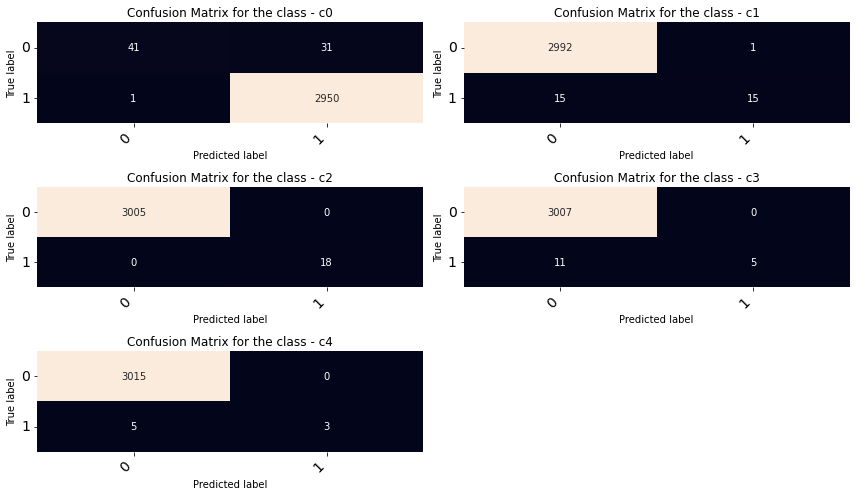

In [37]:
# Perform outlier removed
data_treated = pd.read_csv("../data/treated_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
X, y = data_treated.iloc[:,:-1], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
ylgbm_pred = lgbm_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, ylgbm_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)

print(y_test.value_counts())
print(pd.DataFrame(ylgbm_pred).value_counts())

# Best Model (One Stage Prediction)

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9919
Recall: 0.9993
F1 score: 0.9956
===========Precision, Recall and F1 Score for c1===========
Precision: 0.8571
Recall: 0.6000
F1 score: 0.7059
===========Precision, Recall and F1 Score for c2===========
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000
===========Precision, Recall and F1 Score for c3===========
Precision: 0.8750
Recall: 0.4375
F1 score: 0.5833
===========Precision, Recall and F1 Score for c4===========
Precision: 0.6667
Recall: 0.2500
F1 score: 0.3636
0    2951
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    2973
1      21
2      18
3       8
4       3
dtype: int64


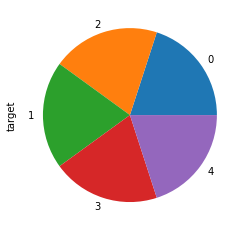

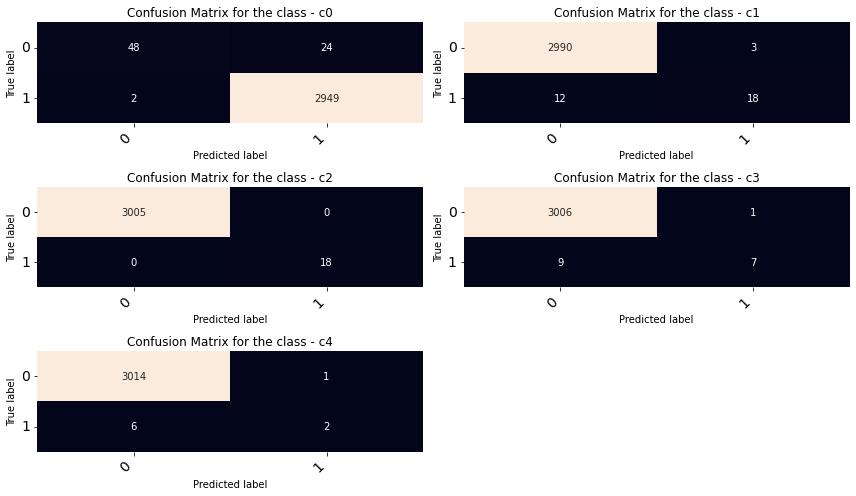

In [36]:
# Best Model
# Perform transformation + outlier removed 
data_treated = pd.read_csv("../data/treated_transformed_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
X, y = data_treated.iloc[:,:-1], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
ylgbm_pred = lgbm_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, ylgbm_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)

print(y_test.value_counts())
print(pd.DataFrame(ylgbm_pred).value_counts())

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9844
Recall: 0.9943
F1 score: 0.9893
===========Precision, Recall and F1 Score for c1===========
Precision: 0.0625
Recall: 0.0333
F1 score: 0.0435
===========Precision, Recall and F1 Score for c2===========
Precision: 0.8824
Recall: 0.8333
F1 score: 0.8571
===========Precision, Recall and F1 Score for c3===========
Precision: 0.5000
Recall: 0.2500
F1 score: 0.3333
===========Precision, Recall and F1 Score for c4===========
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000
0    2976
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    3006
2      17
1      16
3       8
4       1
dtype: int64


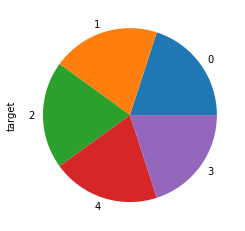

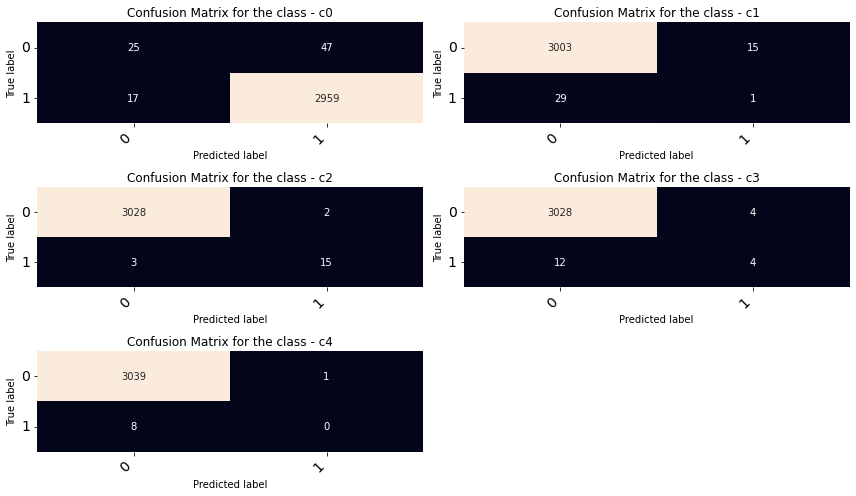

In [47]:
# Best Model
# Perform transformation + outlier removed + feature selection
cols = ['3', '21', '38', '51', '58', '66', '68', '78', '79', '85', '113', '123',
       '132', '140', '141', '142', '145', '146', '15_sqrt', '20_sqrt',
       '90_sqrt', '109_sqrt', '23_log', '92_log', '47_log']
data_treated = pd.read_csv("../data/treated_transformed_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
X, y = data_treated.loc[:,cols], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lgbm_model = LGBMClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
ylgbm_pred = lgbm_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, ylgbm_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, ylgbm_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)

print(y_test.value_counts())
print(pd.DataFrame(ylgbm_pred).value_counts())

c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


===========Precision, Recall and F1 Score for c0===========
Precision: 0.9954
Recall: 0.6499
F1 score: 0.7863
===========Precision, Recall and F1 Score for c1===========
Precision: 0.0240
Recall: 0.3667
F1 score: 0.0450
===========Precision, Recall and F1 Score for c2===========
Precision: 0.5294
Recall: 1.0000
F1 score: 0.6923
===========Precision, Recall and F1 Score for c3===========
Precision: 0.0167
Recall: 0.3750
F1 score: 0.0320
===========Precision, Recall and F1 Score for c4===========
Precision: 0.0079
Recall: 0.2500
F1 score: 0.0153
0    2976
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    1943
1     459
3     359
4     253
2      34
dtype: int64


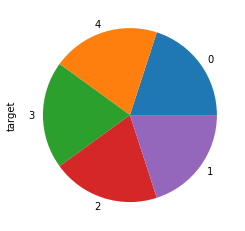

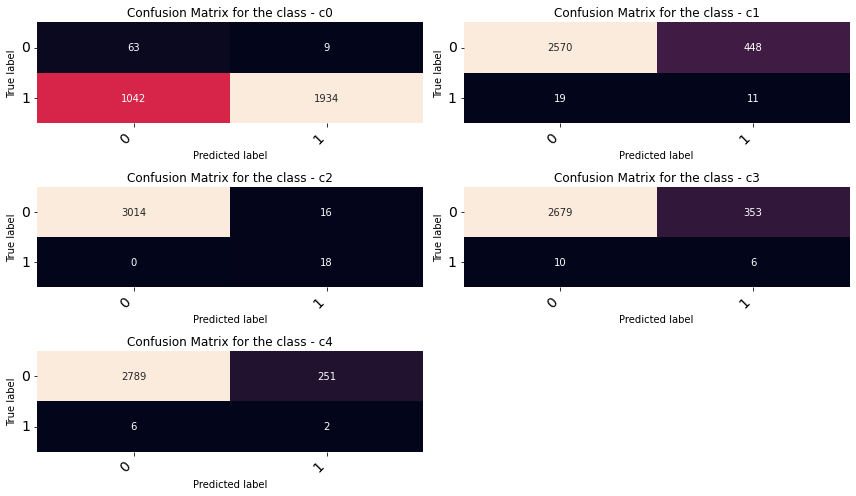

In [46]:
# Perform transformation + outlier removed 
data_treated = pd.read_csv("../data/treated_transformed_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
X, y = data_treated.iloc[:,:-1], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

lro_model = LogisticRegression(solver='newton-cg', class_weight='balanced').fit(X_otrain, y_otrain)
ylro_pred = lro_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, ylro_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, ylro_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, ylro_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, ylro_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)

print(y_test.value_counts())
print(pd.DataFrame(ylro_pred).value_counts())

===========Precision, Recall and F1 Score for c0===========
Precision: 0.9830
Recall: 1.0000
F1 score: 0.9914
===========Precision, Recall and F1 Score for c1===========
Precision: 1.0000
Recall: 0.1667
F1 score: 0.2857
===========Precision, Recall and F1 Score for c2===========
Precision: 1.0000
Recall: 0.8889
F1 score: 0.9412
===========Precision, Recall and F1 Score for c3===========
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000
===========Precision, Recall and F1 Score for c4===========
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000
0    2951
1      30
2      18
3      16
4       8
Name: target, dtype: int64
0    3002
2      16
1       5
dtype: int64


c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


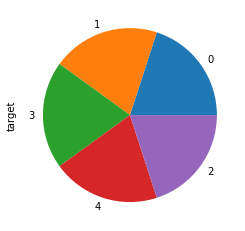

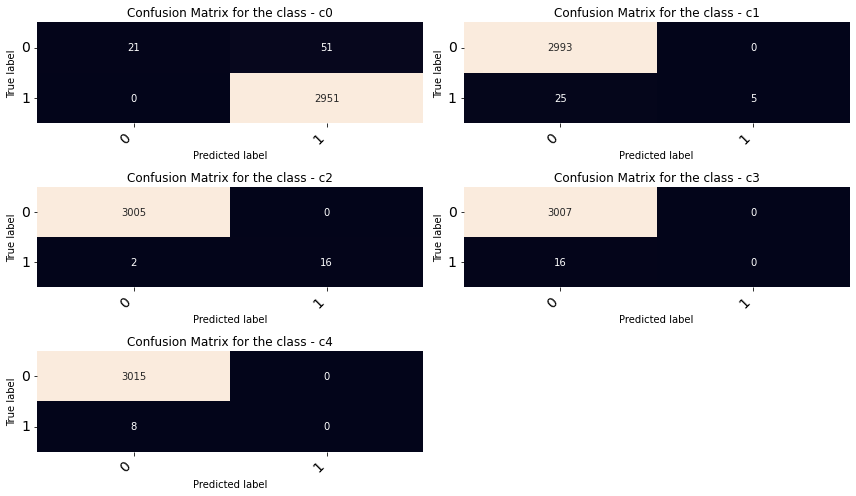

In [41]:
# Perform transformation + outlier removed 
data_treated = pd.read_csv("../data/treated_transformed_data.csv")
data_treated = data_treated[~data_treated.isna().any(axis=1)]
X, y = data_treated.iloc[:,:-1], data_treated['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

oversample = SMOTE()
X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
y_otrain.value_counts(normalize=True).plot.pie()

rfo_model = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
yrfo_pred = rfo_model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, yrfo_pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

labels_metrics = [0,1,2,3,4]
for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========".format(label))
    precision = precision_score(y_test, yrfo_pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)
    recall = recall_score(y_test, yrfo_pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)
    f1 = f1_score(y_test, yrfo_pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)

print(y_test.value_counts())
print(pd.DataFrame(yrfo_pred).value_counts())

# Baseline Model: Artificial neural net

In [236]:
X_train.shape

(7100, 151)

In [253]:
y_test.unique().size

5

In [423]:
def create_model(layers, activation):
    
    keras.backend.clear_session()
    
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print('Summary of neural net model:')
    print(model.summary())
    
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

In [424]:
layers = [[20], [40,20], [45,30,15]]
activation = ['sigmoid', 'relu']
batch_size = [128, 256]
epochs = [30]
param_grid = dict(layers=layers, activation=activation, batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [425]:
grid_result = grid.fit(X_train, ynn_train)

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3040      
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________
None
Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                6080      
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3040      
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________
None
Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                6080      
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3040      
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________
None
Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                6080      
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3040      
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________
None
Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                6080      
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 7,005
Trainable params: 7,005
Non-trainable params: 0
_________________________

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3040      
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________
None


In [428]:
[grid_result.best_score_, grid_result.best_params_]

[0.976478886604309,
 {'activation': 'sigmoid', 'batch_size': 128, 'epochs': 30, 'layers': [20]}]

In [444]:
X_train.shape[1]

151

In [456]:
keras.backend.clear_session()
model = Sequential()
model.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Summary of neural net model:')
print(model.summary())

Summary of neural net model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                2280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 80        
Total params: 2,360
Trainable params: 2,360
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
1136/1136 - 2s - loss: 85.3982 - accuracy: 0.9553 - val_loss: 21.9568 - val_accuracy: 0.9662
Epoch 2/25
1136/1136 - 1s - loss: 28.6444 - accuracy: 0.9574 - val_loss: 44.1878 - val_accuracy: 0.9676
Epoch 3/25
1136/1136 - 2s - loss: 27.9866 - accuracy: 0.9581 - val_loss: 26.2754 - val_accuracy: 0.9676
Epoch 4/25
1136/1136 - 1s - loss: 24.5814 - accuracy: 0.9574 - val_loss: 21.1385 - val_accuracy: 0.9676
Epoch 5/25
1136/1136 - 2s - loss: 21.6647 - accuracy: 0.9579 - val_loss: 41.2294 - val_accuracy: 0.5282
Epoch 6/25
1136/1136 - 2s - loss: 19.1646 - accuracy: 0.9570 - val_loss: 32.2084 - val_accuracy: 0.9676
Epoch 7/25
1136/1136 - 2s - loss: 18.8813 - accuracy: 0.9570 - val_loss: 42.5256 - val_accuracy: 0.9648
Epoch 8/25
1136/1136 - 2s - loss: 18.0643 - accuracy: 0.9576 - val_loss: 27.5900 - val_accuracy: 0.9676
Epoch 9/25
1136/1136 - 2s - loss: 14.4540 - accuracy: 0.9583 - val_loss: 7.5994 - val_accuracy: 0.9648
Epoch 10/25
1136/1136 - 2s - loss: 14.8195 - accuracy: 0.9569 - v

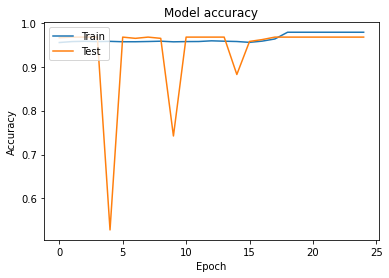

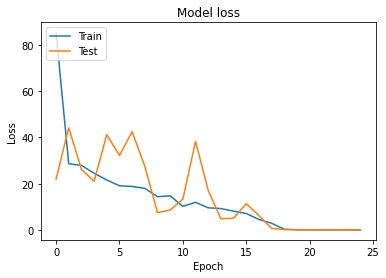

In [450]:
num_epochs = 25
batch_size = 5
history = model.fit(X_train, ynn_train, batch_size=batch_size, epochs=num_epochs, verbose=2, validation_split=0.2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [431]:
# score, acc = model.evaluate(X_test, ynn_test, batch_size=batch_size, verbose=2)
# print('Test accuracy', acc)

In [451]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(ynn_test)):
    test.append(np.argmax(ynn_test[i]))

In [452]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 97.63469119579501


In [366]:
pd.DataFrame(test).value_counts()

0    2972
1      30
2      18
3      16
4       8
dtype: int64

In [453]:
pd.DataFrame(pred).value_counts()

0    3044
dtype: int64

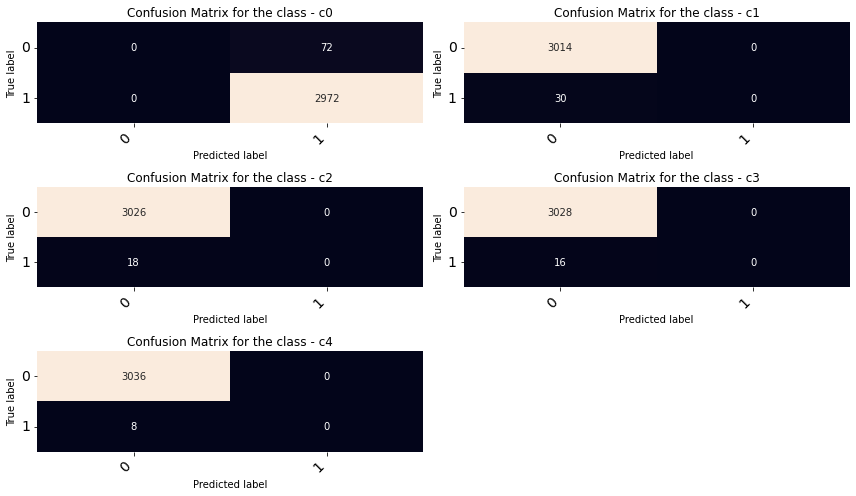

In [284]:
cm = multilabel_confusion_matrix(test, pred)
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
fig.delaxes(ax[2,1])
fig.tight_layout()

In [270]:
labels_metrics = [0,1,2,3,4]

for label in labels_metrics:
    
    print("===========Precision, Recall and F1 Score for c{}===========\n".format(label))
    
    precision = precision_score(test, pred, labels=[label], average='micro')
    print('Precision: %.4f' % precision)

    recall = recall_score(test, pred, labels=[label], average='micro')
    print('Recall: %.4f' % recall)

    f1 = f1_score(test, pred, labels=[label], average='micro')
    print('F1 score: %.4f' % f1)
    
    print("\n")


# if 1-4 is truly defect, recall (all defects identified) would be a preferred metrics over precision (defects identified amongst normal observations)
# c0 and c2 were predicted well, c1, c3 and c4
# let's see if neural nets can predict the 2,3,4 well

===========Precision, Recall and F1 Score for c0===========

Precision: 0.9763
Recall: 0.9832
F1 score: 0.9797


===========Precision, Recall and F1 Score for c1===========

Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


===========Precision, Recall and F1 Score for c2===========

Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


===========Precision, Recall and F1 Score for c3===========

Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


===========Precision, Recall and F1 Score for c4===========

Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000




c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\projects\2021\16_practice\multinomial_classification\python3.7_multinomial\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av